(log-reg-notebook)=
# Modello di regressione logistica

In questo capitolo, approfondiremo la regressione logistica bivariata, una metodologia statistica che ci consente di analizzare le relazioni tra una variabile di risultato binaria e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello attraverso un approccio bayesiano, il quale ci offre stime a posteriori più informative e la possibilità di calcolare intervalli di credibilità per tali coefficienti.

In aggiunta, forniremo un'interpretazione dei risultati ottenuti dalla regressione logistica. Esplicheremo come i coefficienti influenzano la probabilità di successo della variabile binaria di risultato, nonché come interpretare il loro segno e ampiezza. Ciò ci permetterà di comprendere il contributo della variabile indipendente nella modifica della probabilità di ottenere un risultato specifico.

Iniziamo a caricare i pacchetti necessari.

In [60]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [34]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## American National Election Studies (ANES)

In questo tutorial, utilizzeremo un set di dati forniti dal sito di Bambi per illustrare il modello di regressione logistica. Questi dati provengono dallo studio pilota del 2016. Lo studio completo includeva 1200 persone, ma in questo caso, è stato selezionato un sottoinsieme di 487 persone che hanno risposto a una domanda riguardante se avrebbero votato per Hillary Clinton o Donald Trump.

Importiamo i dati.

In [35]:
data = bmb.load_data("ANES")
data.head()

vote  age    party_id
0  clinton   56    democrat
1    trump   65  republican
2  clinton   80    democrat
3    trump   38  republican
4    trump   60  republican

La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

> If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?

Esaminiamo la distribuzione di frequenze della variabile `vote`.

In [36]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

Per semplificare l'analisi, qui considereremo solo le risposte `Clinton` e `Trump`. Ci porremo il problema di modellare la probabilità di voto per Clinton.

In [37]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

vote  age    party_id
0  clinton   56    democrat
1    trump   65  republican
2  clinton   80    democrat
3    trump   38  republican
4    trump   60  republican

Nell'analisi di questi dati, potremmo essere tentati di utilizzare il modello lineare tradizionale; tuttavia, ciò non è possibile in questo caso a causa delle specifiche caratteristiche dei dati. In primo luogo, la variabile $Y$ è di tipo Bernoulliano, ovvero può assumere solo due valori possibili: 0 e 1, corrispondenti a due esiti distinti ("voto per Clinton" o "voto per Trump"). Questa natura discreta e categorica della variabile $Y$ rende incompatibile il modello di regressione tradizionale, che invece è concepito per variabili dipendenti continue.

Inoltre, il modello lineare tradizionale presuppone che l'aspettativa di $Y$, ovvero $E(Y \mid X)$,  sia un valore compreso nell'intervallo da meno infinito a più infinito, mentre $Y$ può assumere solo i valori 0 e 1. Questo aspetto incompatibile limita ulteriormente l'adeguatezza del modello lineare tradizionale per descrivere i dati in questione.

Per superare queste problematiche, possiamo adottare un approccio diverso: prevedere non il valore atteso di $Y$ direttamente, bensì il valore atteso di una sua trasformazione. Questa trasformazione di $Y$ viene chiamata "funzione link". Nella regressione logistica, la funzione link utilizzata è il logit, ovvero il logaritmo dell'odds ratio, rappresentato come: 

$$ 
\log \left( \frac{p}{1-p} \right) 
$$

dove $p$ rappresenta la probabilità di ottenere l'esito 1 nella variabile $Y$.

Il logit può assumere valori nell'intervallo da meno infinito a più infinito, rendendo così appropriato il modello di regressione logistica per dati con variabili di tipo Bernoulliano. Pertanto, il modello di regressione logistica è essenzialmente un modello di regressione lineare che si focalizza sulla previsione di una trasformazione della variabile Bernoulliana $Y$, utilizzando il logaritmo dell'odds ratio come funzione link.

In modo equivalente, la probabilità di $Y$, indicata come $\pi$, può essere espressa come funzione del predittore lineare $\eta = \beta_0 + \beta_1 X$:

$$
\pi = \frac{e^\eta}{1 + e^\eta} = \frac{1}{1 + e^{-\eta}}.
$$

In questo modo, otteniamo un modello non lineare.

Nel nostro esempio, utilizzeremo un modello di regressione logistica per stimare la probabilità di votare per Clinton in funzione dell'età. Il nostro obiettivo è quindi modellare $\pi = P(Y = 1)$, ovvero la probabilità di votare per Clinton, utilizzando l'età come variabile esplicativa.

La regressione logistica collega il logit di $\pi$ a un predittore o a una combinazione lineare di predittori. Nella nostra situazione, l'equazione matematica del modello sarà la seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X,
$$

dove $X$ rappresenta l'età.

Inoltre, per utilizzare l'approccio bayesiano, dobbiamo specificare una distribuzione a priori per i parametri e una funzione di verosimiglianza. Nella nostra analisi, utilizzeremo le distribuzioni a priori predefinite di Bambi e la verosimiglianza sarà il prodotto delle prove Bernoulliane, ovvero il prodotto delle probabilità

$$
\prod_{i=1}^{n}{p_i^{y_i}(1-p_i)^{1-y_i}},
$$

dove $p_i = P(Y=1)$ e $y_i = 1$ se l'intenzione di voto è per Clinton e $y_i = 0$ se è per Trump.

### Specificare e adattare il modello in Bambi

La specificazione e l'adattamento del modello si dimostrano semplici e intuitivi mediante Bambi. Per utilizzare Bambi, è sufficiente formulare il modello utilizzando la sintassi delle formule [@wilkinson1973symbolic] e fornire l'argomento `family` corretto. Si noti l'utilizzo di una sintassi facoltativa sul lato sinistro della formula: `vote[clinton]` comunica a Bambi l'intenzione di modellare la probabilità di `vote=='clinton'`, anziché quella di `vote=='trump'`.

Nel lato destro della formula, utilizziamo il termine `age` per indicare a Bambi che desideriamo considerare solamente `age` come variabile esplicativa nel modello.

In [38]:
clinton_model = bmb.Model(
    "vote['clinton'] ~ age", clinton_data, family="bernoulli"
)

Procediamo con il campionamento. L'argomento opzionale `idata_kwargs={"log_likelihood": True}` richiede il calcolo del logaritmo della verosimiglianza (log-likelihood) durante l'adattamento. Questo passaggio è rischiesto per potere utilizzare in seguito varie funzioni che valutano quanto bene il modello si adatta ai dati.

In [39]:
clinton_fitted = clinton_model.fit(
    idata_kwargs={"log_likelihood": True},
)

Modeling the probability that vote==clinton


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Possiamo stampare l'oggetto `clinton_model` per visualizzare informazioni sulla distribuzione della risposta, la funzione link e le distribuzioni a priori.

In [29]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Otteniamo una rappresentazione delle distribuzioni a priori usate da Bambi.

Sampling: [Intercept, age]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>], dtype=object)

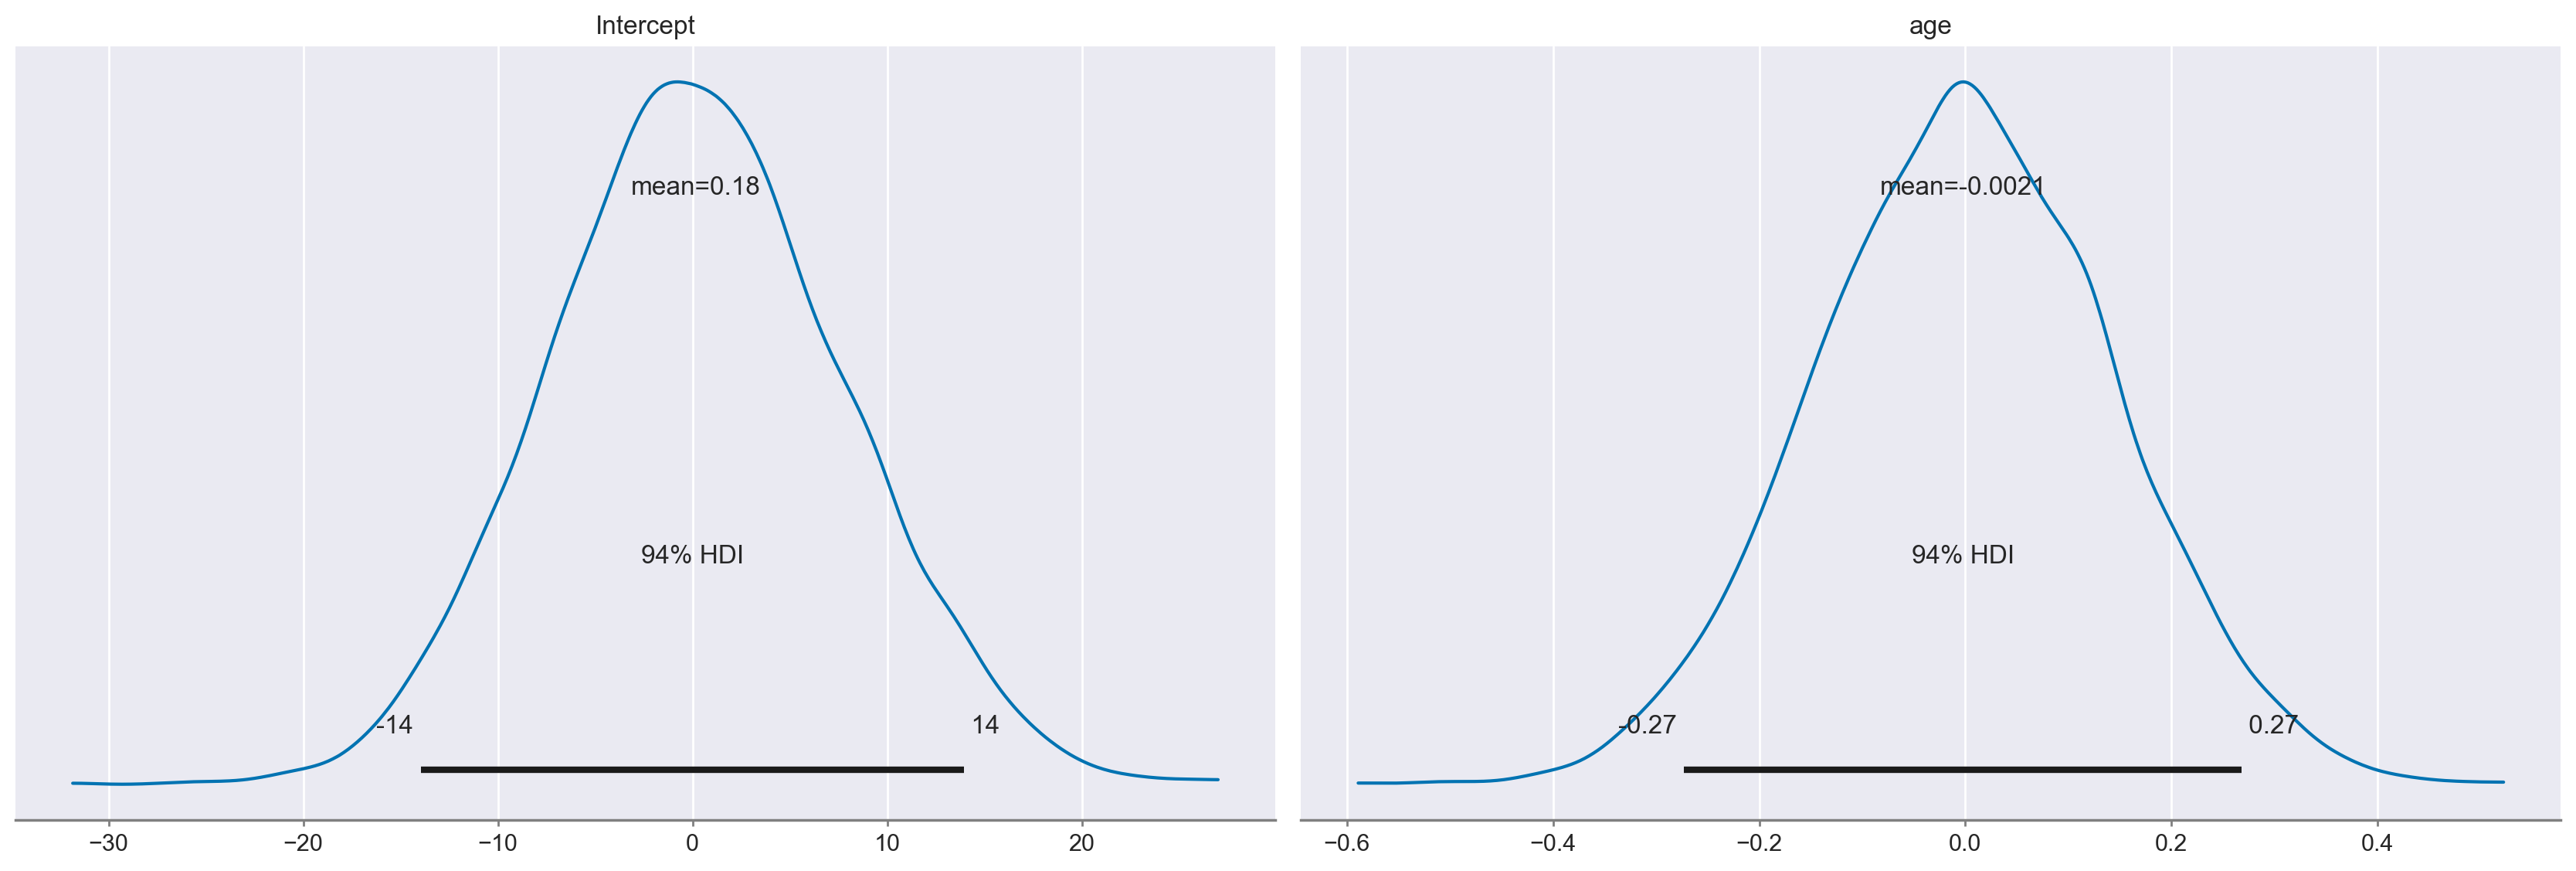

In [30]:
clinton_model.plot_priors()

## Valutazione del modello

Esaminiamo i trace plot delle distribuzioni a posteriori dei parametri.

/Users/corrado/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (375), generating only 20 plots
  warnings.warn(


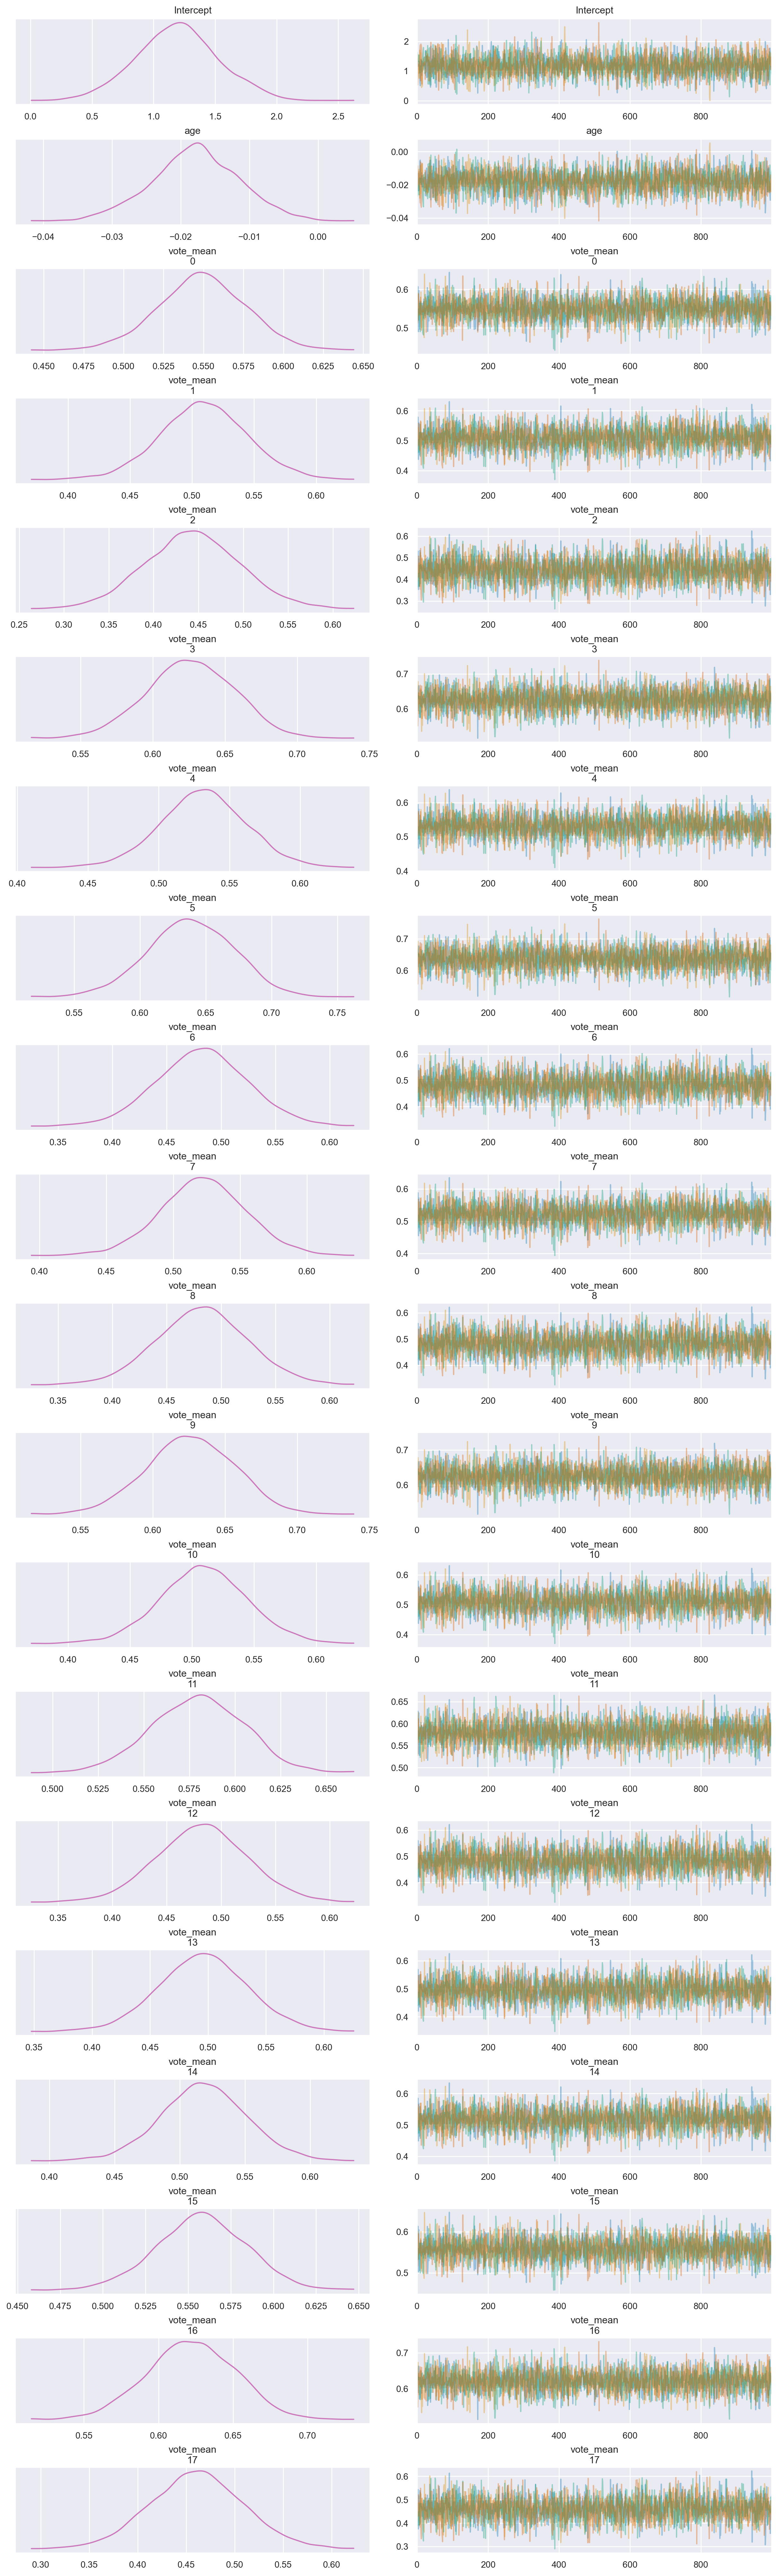

In [24]:
az.plot_trace(clinton_fitted, combined=True, compact=False);

### Posterior Predictive Check

Generiamo le previsioni posteriori dal modello di regressione logistica bivariata adattato ai dati di voto per Clinton. Il parametro `clinton_fitted` rappresenta l'output dell'adattamento del modello, che contiene le stime posteriori dei parametri del modello. Il parametro `kind="pps"` indica il tipo di previsione che vogliamo ottenere, nel caso specifico "pps" sta per "posterior predictive samples" (campioni predittivi posteriori). Questo significa che stiamo generando campioni casuali da una distribuzione predittiva basata sui parametri stimati e sulle distribuzioni a posteriori. In altre parole, stiamo simulando possibili risultati futuri o predizioni che potrebbero verificarsi dato il modello adattato ai dati.

In [27]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

Otteniamo il Posterior Preditive Check.

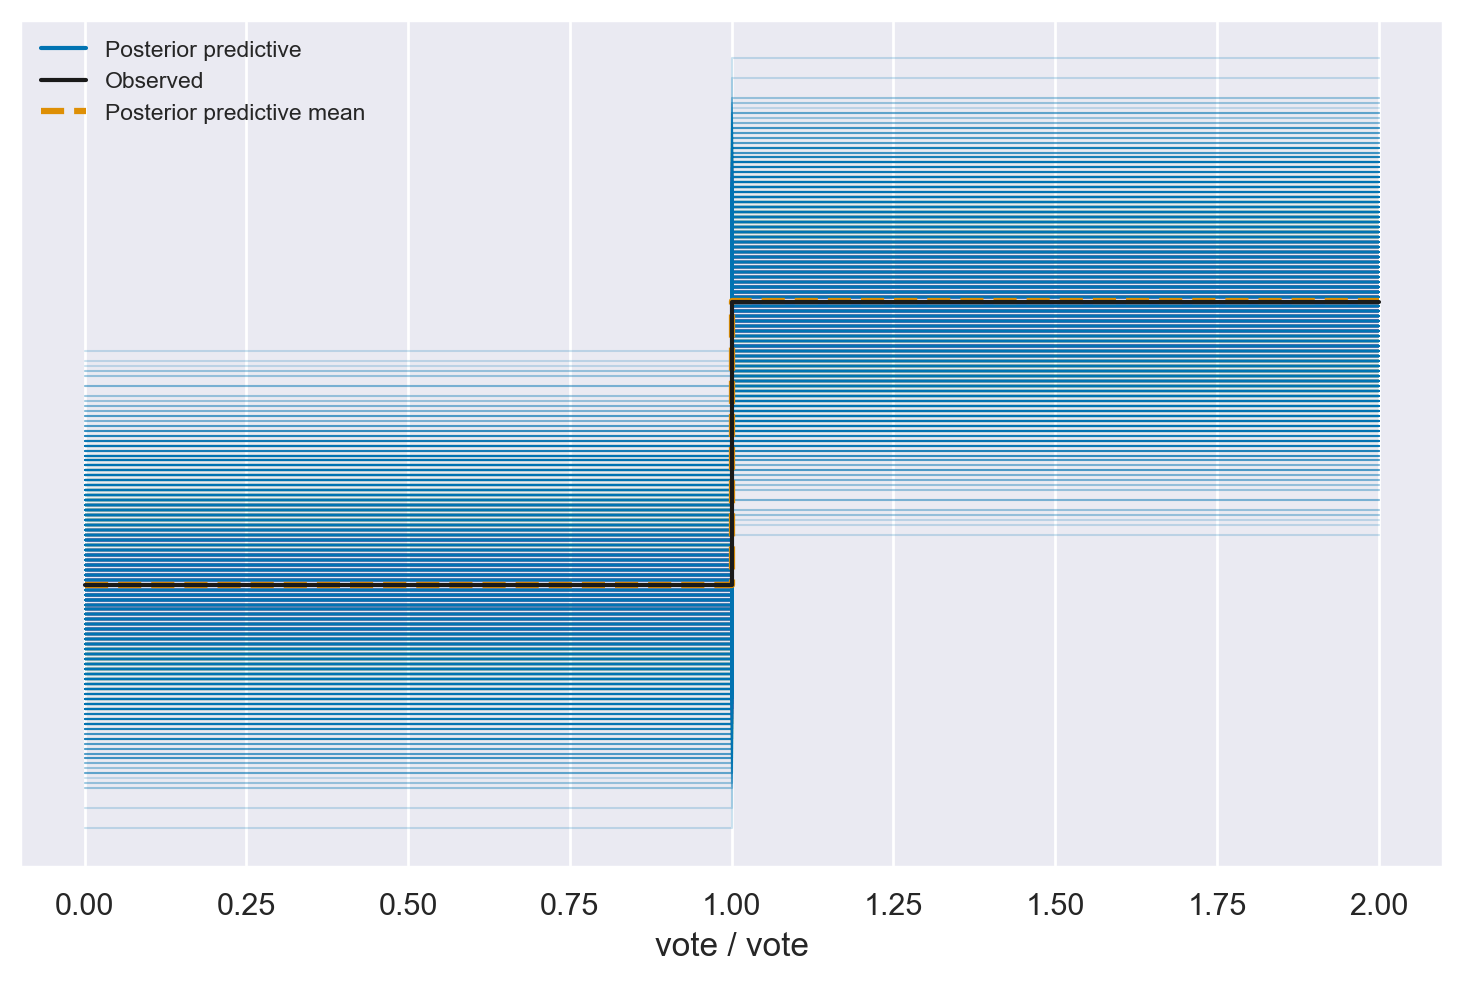

In [28]:
az.plot_ppc(clinton_fitted);

I possibili risultati futuri sono coerenti con i dati osservati, il che fornisce evidenze di un buon adattamento del modello.

## Parametro $\hat \kappa$

Possiamo utilizzare anche ArviZ per calcolare [LOO](https://arxiv.org/abs/1507.04544) e individuare le osservazioni che hanno un impatto significativo, basandoci sul valore stimato del parametro $\hat \kappa$. 

In [17]:
loo = az.loo(clinton_fitted, pointwise=True)

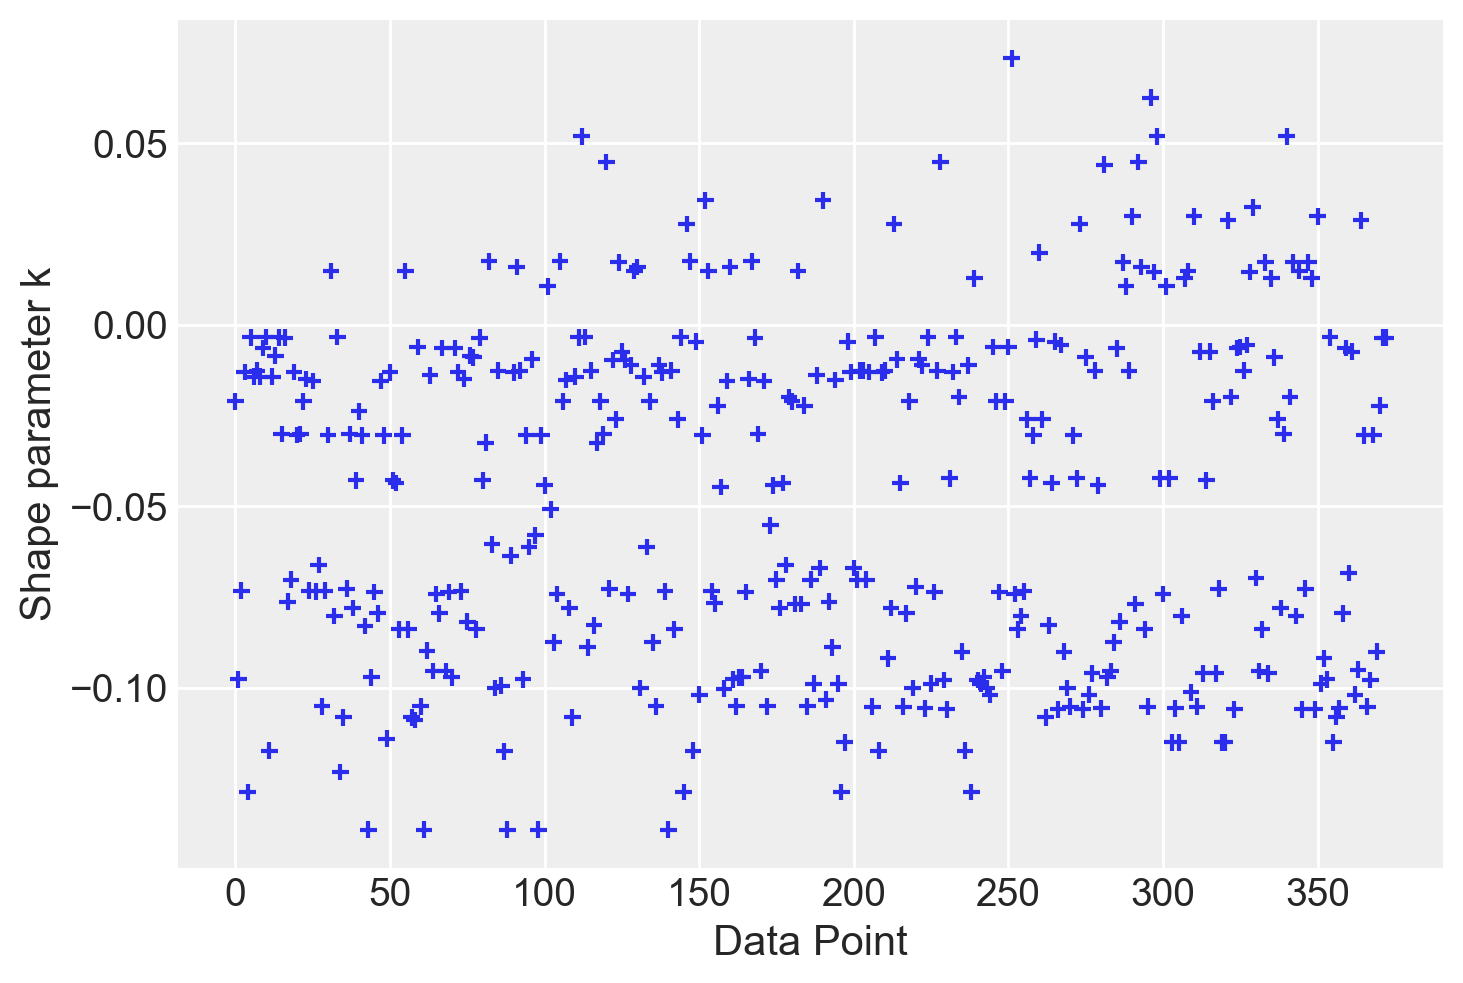

In [18]:
# plot kappa values
az.plot_khat(loo.pareto_k);

L'andamento dei valori di $\hat \kappa$ nel grafico evidenzia che la maggior parte di essi è concentrata in un intervallo che arriva approssimativamente fino a 0.05. Oltre questo valore, si notano solo pochi punti che si discostano. Questa distribuzione non suggerisce la presenza di osservazioni particolarmente influenti, il che indica che il modello si adatta bene ai dati.

## Inferenza

Esaminiamo una sintesi delle distribuzioni a posteriori dei parametri.

In [20]:
az.summary(clinton_fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.195  0.335   0.580    1.855      0.006    0.004    3694.0   
age            -0.018  0.006  -0.029   -0.005      0.000    0.000    3373.0   
vote_mean[0]    0.549  0.028   0.496    0.601      0.000    0.000    3322.0   
vote_mean[1]    0.509  0.035   0.443    0.577      0.001    0.000    3115.0   
vote_mean[2]    0.443  0.053   0.345    0.547      0.001    0.001    3108.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.605  0.027   0.554    0.654      0.000    0.000    4015.0   
vote_mean[369]  0.592  0.026   0.541    0.638      0.000    0.000    3948.0   
vote_mean[370]  0.514  0.034   0.446    0.576      0.001    0.000    3131.0   
vote_mean[371]  0.622  0.030   0.566    0.675      0.000    0.000    4013.0   
vote_mean[372]  0.622  0.030   0.566    0.675      0.000    0.000    4013.0   

                ess_tail  r_hat  
Intercept         2919.0    1.0  
age               2785.0    1.0  
vote_mean[0]      2947.0    1.0  
vote_mean[1]      2904.0    1.0  
vote_mean[2]      2823.0    1.0  
...                  ...    ...  
vote_mean[368]    2862.0    1.0  
vote_mean[369]    2890.0    1.0  
vote_mean[370]    2869.0    1.0  
vote_mean[371]    2893.0    1.0  
vote_mean[372]    2893.0    1.0  

[375 rows x 9 columns]

### Interpretazione dei coefficienti nella regressione logistica

Sulla base delle distribuzioni a posteriori dei parametri, possiamo scrivere l'equazione del modello di regressione logistica nel modo seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = 1.195 - 0.018 \cdot \text{età}.
$$

### Interpretazione di $\beta_0$

Quando il predittore $X$ è pari a 0, $\beta_0$ rappresenta il logit dell'evento di interesse (voto per Clinton) e $e^{\beta_0}$ rappresenta gli odds di successo ($\pi / (1-\pi)$).

Nel caso presente, dunque, per un'età pari a 0, gli odds di successo ($\pi / (1-\pi)$) sono pari a

In [29]:
np.exp(1.195)

3.3035577705016714

e la probabilità di un voto per Clinton è

In [30]:
np.exp(1.195) / (1 + np.exp(1.195))

0.7676341173216252

Tuttavia, nel caso presente, l'intercetta non fornisce informazioni utili. Se avessimo trasformato i dati codificando l'età come scarti dalla media, le interpretazioni precedenti sarebbero riferite all'età media del campione, il che avrebbe più senso.

### Interpretazione di $\beta_1$

Quando $X$ aumenta di 1, da $x$ a $x+1$, $\beta_1$ rappresenta il cambiamento tipico nel logit, e $e^{\beta_1}$ rappresenta il cambiamento tipico moltiplicativo negli odds:

$$
\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x) \quad \text{e} \quad e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}.
$$

In altre parole, sulla scala lineare dei logit, il coefficiente $\beta_1$ rappresenta semplicemente la pendenza: per un cambiamento unitario dell'età, i logit del voto per Clinton diminuiscono di -0.018. 

Tuttavia, è più facile interpretare questo risultato sulla scala non lineare degli odds, dove questa variazione è moltiplicativa: per ogni anno di aumento dell'età, gli odds stimati dell'evento (votare per Clinton) vengono moltiplicati per $e^{\beta_1}$:

In [31]:
np.exp(-0.018)

0.9821610323583008

Poiché la relazione di probabilità è una curva sigmoidale, non possiamo interpretare facilmente il coefficiente $\beta_1$ su questa scala. È invece preferibile rappresentare graficamente come varia la probabilità attesa di "successo" al variare dell'età. La rappresentazione di questa relazione, basata sulle stime a posteriori del modello, è fornita di seguito.

In [32]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

age
0     18
1     19
2     20
3     21
4     22
..   ...
214   86
215   87
216   88
217   89
218   90

[219 rows x 1 columns]

In [33]:
clinton_model.predict(clinton_fitted, data=new_data)

In [34]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

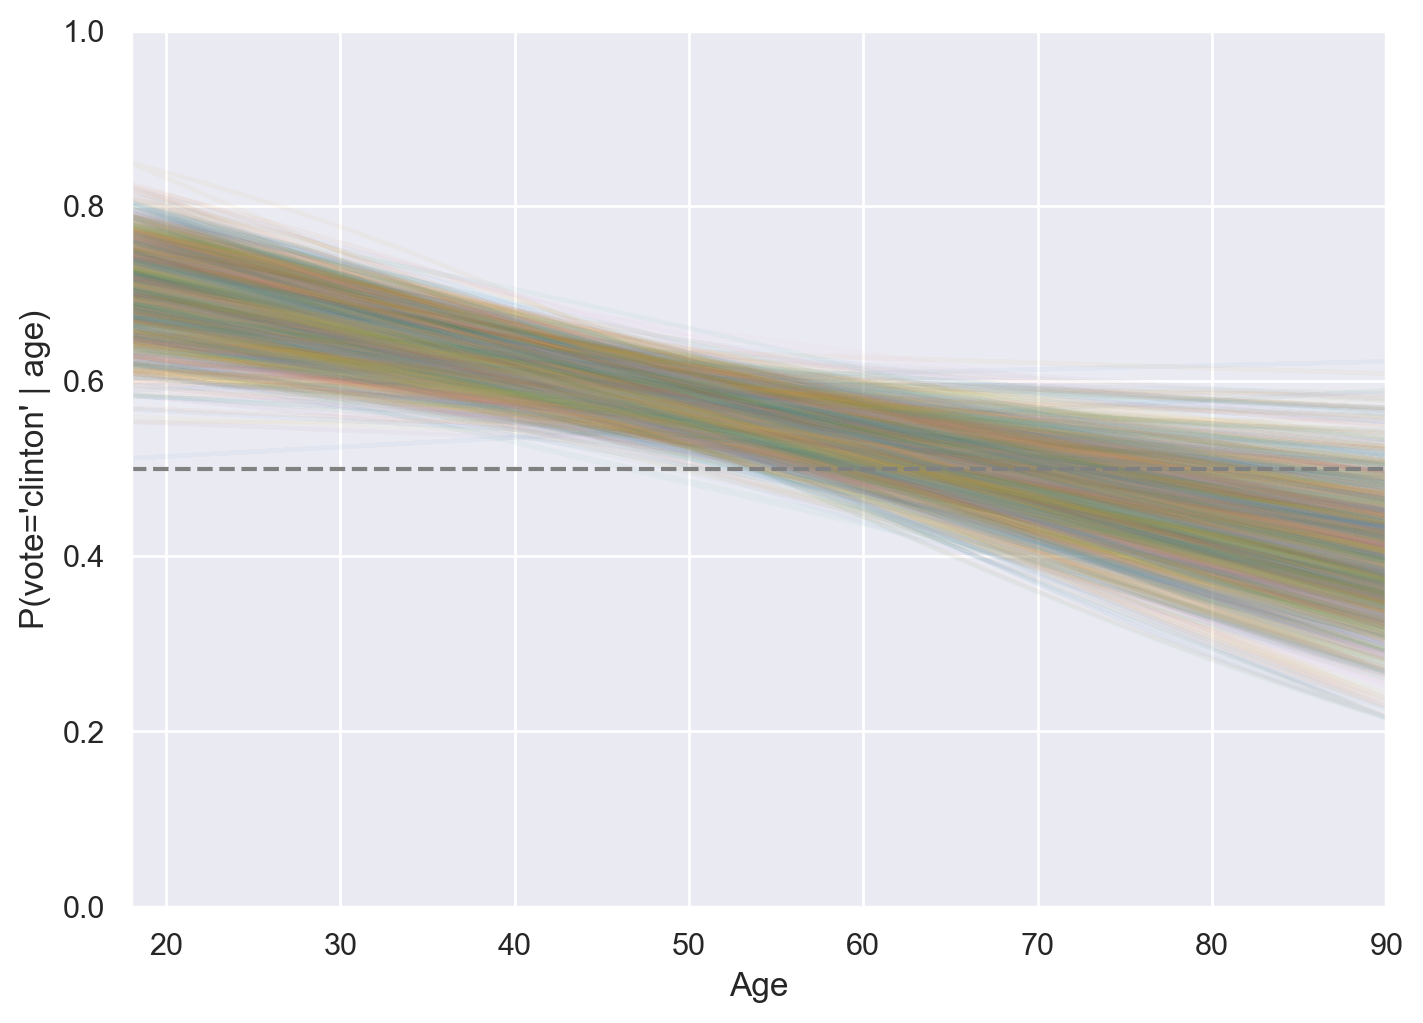

In [35]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(new_data.age, vote_posterior, alpha=0.04)

# Adding a dashed horizontal line at y=0.5 (50% probability)
ax.axhline(y=0.5, color="gray", linestyle="dashed")

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age")
ax.set_ylim(0, 1)
ax.set_xlim(18, 90)

plt.show()

Possiamo interpretare il grafico precedente nel seguente modo: fino a circa 65 anni, l'intenzione di voto per Clinton è maggiore dell'intenzione di voto per Trump; dopo i 65 anni, la situazione si inverte.

Il fatto che la figura riporti molteplici curve (2000 nel caso presente) ci informa sull'incertezza a posteriori delle predizioni del modello.

## Accuratezza delle classificazioni a posteriori

Esaminiamo ora la precisione delle nostre classificazioni posteriori. Nell'ambito della regressione, quando affrontiamo una variabile quantitativa  $Y$, abbiamo risposto a questa domanda analizzando la tipica differenza tra $Y$ e le sue previsioni posteriori. Tuttavia, nel contesto della classificazione con una variabile $Y$ categorica, le nostre classificazioni posteriori binarie di $Y$ possono essere corrette oppure errate. Pertanto, possiamo calcolare un indicatore globale di precisione.

Per procedere con il calcolo, il primo passo è determinare la probabilità a posteriori $P(Y = 1 | X)$, ovvero la probabilità che ciascuna osservazione rappresenti un voto per Clinton, per ogni singola osservazione.

Calcoliamo le probabilità predette dai coefficienti a posteriori del modello:

In [48]:
clinton_model.predict(clinton_fitted)

Le probabilità a posteriori possono essere estratte dall'oggetto `clinton_model` nel modo seguente.

In [51]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.54045178, 0.49085773, 0.40907327, ..., 0.49637718,
         0.63124216, 0.63124216],
        [0.51399037, 0.45578683, 0.36212898, ..., 0.46222351,
         0.62166906, 0.62166906],
        [0.52536895, 0.48225277, 0.41128518, ..., 0.48704215,
         0.60528867, 0.60528867],
        ...,
        [0.59661804, 0.55903732, 0.49509032, ..., 0.56325485,
         0.66430565, 0.66430565],
        [0.59500129, 0.56643159, 0.5179136 , ..., 0.56963158,
         0.64711556, 0.64711556],
        [0.52544299, 0.47610351, 0.39535515, ..., 0.48158026,
         0.61655491, 0.61655491]],

       [[0.58462678, 0.53786188, 0.45883695, ..., 0.54310662,
         0.66836403, 0.66836403],
        [0.57666365, 0.527972  , 0.4460919 , ..., 0.53342595,
         0.66404396, 0.66404396],
        [0.50751052, 0.45669362, 0.37445095, ..., 0.46231491,
         0.60224315, 0.60224315],
...
        [0.55131931, 0.47778712, 0.35883337, ...

Otteniamo così un array multidimensionale di dimensioni avente le seguenti dimensioni: chain: 4, draw: 1000, vote_obs: 373. Vogliamo la media a posteriori per ciascuna osservazione, ovvero vogliamo ridurre l'array precedente ad un vettore di 373 elementi. A questo fine possiamo procedere come indicato di seguito.

In [58]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_69176/211204809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["probs"] = average_posterior_values.values


vote  age    party_id     probs
0  clinton   56    democrat  0.548777
1    trump   65  republican  0.508829
2  clinton   80    democrat  0.442730
3    trump   38  republican  0.626205
4    trump   60  republican  0.531058

Creaiamo la variabile `predicted` che assume il valore 1 se la probabilità di un'osservazione è maggiore di 0.5 e 0 altrimenti.

In [ ]:
# Create predicted classes based on probs
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int)

Classifichiamo le osservazioni ricodificando il voto "clinton" con 1 e 0 altrimenti.

In [ ]:
# Create actual classes based on vote
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

Creiamo una matrice di confusione.

In [61]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 33 125]
 [ 31 184]]


/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_69176/1624278455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int)
/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_69176/1624278455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)


### Sensibilità, specificità e accuratezza complessiva

Sia  $Y$  un insieme di valori di risposta binari su  $n$  punti dati e  $\hat{Y}$  rappresenti le corrispondenti classificazioni posteriori di  $Y$. Una matrice di confusione riassume i risultati di queste classificazioni rispetto alle osservazioni effettive, dove  $a + b + c + d = n$:

$\hat{Y} = 0$ | $\hat{Y} = 1$
--- | ---
$Y = 0$ | $a$ | $b$
$Y = 1$ | $c$ | $d$

L'accuratezza complessiva del modello cattura la proporzione di tutte le osservazioni  $Y$  che sono classificate correttamente:

$$
\text{accuratezza complessiva} = \frac{a + d}{a + b + c + d}.
$$

Inoltre, la sensibilità del modello (tasso di veri positivi) cattura la proporzione di osservazioni $Y = 1$  classificate correttamente e la specificità (tasso di veri negativi) cattura la proporzione di osservazioni  $Y = 0$  classificate correttamente:

$$
\text{sensibilità} = \frac{d}{c + d} \quad \text{e} \quad \text{specificità} = \frac{a}{a + b}.
$$

Per i dati presenti abbiamo un'accuratezza complessiva di

In [62]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

Abbiamo una sensibilità di

In [63]:
184/ (31+184)

0.8558139534883721

e una specificità di

In [64]:
33 / (33+125)

0.2088607594936709

Questi risultati indicano che il modello ha una capacità predittiva molto limitata, soprattutto se consideriamo la sua specificità. È evidente che è stato troppo ambizioso tentare di predire le intenzioni di voto basandosi unicamente sull'età. Questo tutorial rappresenta una versione semplificata dell'esempio discusso nel sito di Bambi, dove, oltre all'età, viene utilizzata anche l'appartenenza a un partito politico come predittore. In quel contesto, è chiaro che l'intenzione di voto può essere prevista con una precisione maggiore. Nell'esempio attuale, a fini didattici, abbiamo volutamente semplificato il modello per avere un unico predittore.

## Funzione logistica

Per chi fosse interessato, possiamo esaminare i passaggi algebrici che che trasformano l'equazione iniziale $\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X$ nell'equazione $\pi = \frac{e^\eta}{1 + e^\eta}$.

Partiamo dall'equazione iniziale:

   $$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X.$$
   
Applichiamo la funzione esponenziale ad entrambi i lati dell'equazione per eliminare il logaritmo:

   $$\exp\left(\log{\left(\frac{\pi}{1 - \pi}\right)}\right) = \exp(\beta_0 + \beta_1 X).$$

Utilizziamo la proprietà $\exp(\log(a)) = a$ per semplificare il lato sinistro dell'equazione:

   $$\frac{\pi}{1 - \pi} = \exp(\beta_0 + \beta_1 X).$$

Moltiplichiamo entrambi i lati dell'equazione per $(1 - \pi)$:

   $$\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X).$$

Dalla precedente equazione $\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X)$, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi) \cdot \exp(\beta_0 + \beta_1 X) \cdot \exp(-\beta_0 - \beta_1 X).$$

Semplificando, otteniamo:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi).$$

Ora, dividiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\frac{\pi \cdot \exp(-\beta_0 - \beta_1 X)}{\exp(-\beta_0 - \beta_1 X)} = \frac{(1 - \pi)}{\exp(-\beta_0 - \beta_1 X)}.$$

Semplificando ulteriormente, abbiamo:

$$\pi = \frac{1 - \pi}{\exp(-\beta_0 - \beta_1 X)}.$$

Ora, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = 1 - \pi.$$

Mettiamo $\pi$ da un lato e semplifichiamo il lato destro:

$$\pi + \pi \cdot \exp(-\beta_0 - \beta_1 X) = 1.$$

Ora, estraiamo $\pi$ come un fattore comune:

$$\pi \cdot (1 + \exp(-\beta_0 - \beta_1 X)) = 1.$$

Infine, isoliamo $\pi$ dividendo entrambi i lati per $(1 + \exp(-\beta_0 - \beta_1 X))$:

$$\pi = \frac{1}{1 + \exp(-\beta_0 - \beta_1 X)}.$$

Ponendo $\eta = \beta_0 + \beta_1 X$, possiamo scrivere la stessa espressione come:

$$\pi = \frac{\exp(\eta)}{1 + \exp(\eta)},$$

o anche come:

$$\pi = \frac{1}{1 + \exp(-\eta)}.$$

Questa forma finale è nota come funzione logistica o funzione sigmoide, ed è utilizzata per mappare il logit delle probabilità $\eta$ nella probabilità stessa $\pi$.


## Commenti e considerazioni finali

In questo capitolo, abbiamo esplorato il modello di regressione logistica, una tecnica statistica utilizzata per analizzare le relazioni tra variabili binarie e variabili indipendenti, sia continue che categoriche. Abbiamo spiegato come il modello di regressione logistica impieghi il logit delle probabilità per modellare il legame tra le variabili di risultato e i predittori. La funzione logit trasforma l'intervallo di probabilità da 0 a 1 in un intervallo da meno infinito a più infinito, rendendo possibile l'utilizzo di un modello di regressione lineare nel caso di variabili dipendenti dicotomiche.

In aggiunta, abbiamo illustrato come interpretare i coefficienti nel contesto del modello di regressione logistica. Quando il modello coinvolge una singola variabile indipendente, la rappresentazione grafica delle probabilità attese si rivela uno strumento di grande valore per ottenere una comprensione più accurata dei risultati.

Infine, abbiamo introdotto l'approccio bayesiano per ottenere stime a posteriori dei parametri. Questo approccio ci permette di ottenere una visione più completa delle incertezze legate alle stime dei coefficienti. Attraverso l'aggiornamento bayesiano, siamo in grado di calcolare intervalli di credibilità in base al grado di certezza soggettiva desiderato, offrendo così un ulteriore livello di informazione e interpretazione all'analisi.

## Watermark

In [19]:
%watermark -n -u -v -iv -w

Last updated: Fri Aug 04 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.1
numpy     : 1.25.2
bambi     : 0.12.0
pandas    : 2.0.3
seaborn   : 0.12.2
arviz     : 0.16.1

Watermark: 2.4.3

